In [1]:
from preprocessing import (
    preprocess_kjv,
    get_word_types_with_tf_idf,
    get_gospel_top_70_words_dictionary,
)
from extract_relations import (
    get_directed_relations,
    order_directed_relations,
)
from ontology_algorithm import (
    construct_ontology_hierarchy,
    print_hierarchy_tree_from_ontology,
    draw_hierarchy_tree_from_ontology,
)

## Preprocessing

We will preprocess words from the kjv Bible using tf-idf and extract the top n words.

In [2]:
kjv_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/t_kjv.csv"
kjv_bible_df = preprocess_kjv(
    path_to_kjv=kjv_path,
)

# Get book column unique values.
all_books = kjv_bible_df["book"].unique()

# Specify the books to use as corpus.
# chosen_books = all_books[39:40]

# Disciples
# chosen_books = [
#     "Hebrews",
#     "1 John",
#     "Galatians",
#     "2 Timothy",
#     "Titus",
#     "2 Corinthians",
#     "Philippians",
#     "1 Peter",
#     "1 Corinthians",
#     "James",
#     "Colossians",
#     "Ephesians",
#     "2 John",
#     "3 John",
#     "Romans",
#     "1 Timothy",
#     "2 Peter",
#     "Jude",
#     "1 Thessalonians",
#     "Philemon",
#     "2 Thessalonians",
# ]

# Evangelists
chosen_books = [
    "Matthew",
    "Luke",
    # "Acts",
    # "Revelation",
    "John",
    "Mark",
]


print("Chosen books: ", chosen_books)

# Specify the number of top words to use.
n = 70

text_per_chapter = []
for book in chosen_books:
    book_df = kjv_bible_df[kjv_bible_df["book"] == book]
    for chapter in book_df["chapter"].unique():
        chapter_df = book_df[book_df["chapter"] == chapter]
        text_per_chapter.append(" ".join(chapter_df["text"].values))

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    text_per_chapter,
    "tf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=False,
)

top_n_words = tf_idf_pre_filtering.head(n)["word"].values

# Add disciples names to the top words.
# import numpy as np
# top_n_words = np.concatenate(
#     (top_n_words, np.array(["peter", "james", "john", "andrew", "philip", "nathanael", "thomas", "bartholomew", "matthew", "james", "simon", "judas", "judas iscariot"]))
# )

top_n_words

Chosen books:  ['Matthew', 'Luke', 'John', 'Mark']


array(['unto', 'shall', 'jesus', 'man', 'son', 'god', 'things', 'thy',
       'father', 'lord', 'disciples', 'day', 'men', 'many', 'house',
       'kingdom', 'people', 'world', 'upon', 'great', 'john', 'good',
       'peter', 'may', 'might', 'among', 'days', 'way', 'hand', 'jews',
       'would', 'life', 'name', 'pharisees', 'mother', 'time', 'word',
       'children', 'city', 'jerusalem', 'dead', 'certain', 'master',
       'chief', 'spirit', 'temple', 'multitude', 'hour', 'priests',
       'simon', 'bread', 'galilee', 'place', 'whole', 'christ', 'servant',
       'scribes', 'woman', 'nothing', 'brother', 'earth', 'thine', 'king',
       'prophet', 'hands', 'pilate', 'light', 'sea', 'mary', 'wife'],
      dtype=object)

In [3]:
tf_idf_pre_filtering.head(70)

,word,word_type,tc,tf,dc,idf,tf_idf
0,unto,"{'JJ': 561, 'NN': 18, 'IN': 780, 'NNP': 3, 'RP...",1469,0.017483,89,0.000000,0.000000
1,shall,"{'MD': 900, 'NNP': 4, 'PERSON': 1}",904,0.010759,86,0.034289,0.000369
4,jesus,"{'NNP': 624, 'PERSON': 569, 'ORGANIZATION': 9,...",625,0.007438,79,0.119189,0.000887
6,man,"{'NN': 474, 'NNP': 6, 'PERSON': 6}",480,0.005713,83,0.069796,0.000399
9,son,"{'NN': 171, 'NNP': 153, 'PERSON': 14, 'ORGANIZ...",324,0.003856,75,0.171148,0.000660
...,...,...,...,...,...,...,...
132,pilate,"{'NNP': 52, 'PERSON': 21, 'GPE': 6, 'ORGANIZAT...",52,0.000619,7,2.542726,0.001574
134,light,"{'NN': 35, 'VB': 1, 'JJ': 11, 'NNP': 4, 'GPE':...",52,0.000619,23,1.353142,0.000837
135,sea,{'NN': 51},51,0.000607,23,1.353142,0.000821
137,mary,"{'NNP': 51, 'PERSON': 35}",51,0.000607,17,1.655423,0.001005


In [4]:
# print the row with word "cross"
tf_idf_pre_filtering[tf_idf_pre_filtering["word"] == "jacob"]

,word,word_type,tc,tf,dc,idf,tf_idf
490,jacob,"{'NNP': 14, 'PERSON': 11, 'GPE': 3}",14,0.000167,9,2.291412,0.000382


# Extract relations from the corpus

In [5]:
# Create a list of all verses of the chosen books.
all_verses = []
for book in chosen_books:
    book_df = kjv_bible_df[kjv_bible_df["book"] == book]
    for chapter in book_df["chapter"].unique():
        chapter_df = book_df[book_df["chapter"] == chapter]
        for verse in chapter_df["text"].values:
            all_verses.append(verse)

In [6]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc_1 = nlp(all_verses[3215])
spacy.displacy.render(doc_1, style="dep", jupyter=True)

In [7]:
top_n_words_gender_dict = get_gospel_top_70_words_dictionary()

directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=top_n_words,
    all_verses=all_verses,
    verbose=True,
    top_n_words_gender_dictionary=top_n_words_gender_dict,
)


 1  sentences in verse  0
sentence:  The book of the generation of Jesus Christ, the son of David, the son of Abraham.
ents:  [Jesus Christ, David, Abraham]

 1  sentences in verse  1
sentence:  Abraham begat Isaac; and Isaac begat Jacob; and Jacob begat Judas and his brethren;
ents:  [Abraham begat Isaac, Isaac begat Jacob, Jacob begat Judas]
subject:  Abraham
object:  Isaac
subject:  Isaac
object:  Jacob
subject:  Jacob
object:  Judas

 1  sentences in verse  2
sentence:  And Judas begat Phares and Zara of Thamar; and Phares begat Esrom; and Esrom begat Aram;
ents:  [Zara of Thamar, Phares begat Esrom, Esrom begat Aram]
subject:  Judas
object:  Phares
object:  Thamar
subject:  Phares

 1  sentences in verse  3
sentence:  And Aram begat Aminadab; and Aminadab begat Naasson; and Naasson begat Salmon;
ents:  [Aram begat Aminadab, Aminadab begat Naasson, Naasson]

 1  sentences in verse  4
sentence:  And Salmon begat Booz of Rachab; and Booz begat Obed of Ruth; and Obed begat Jesse;
ent

In [11]:
for key, value in relations_to_verbs.items():
    print(key, value)

('jesus', 'disciples') ['constrained', 'called', 'asked', 'said', 'said', 'said', 'said', 'baptized', 'sat', 'distributed', 'went', 'shewed', 'shewed', 'withdrew', 'called', 'asked']
('jesus', 'galilee') ['went', 'came', 'departed', 'returned', 'came', 'come', 'come', 'went', 'walked', 'came', 'came']
('jesus', 'house') ['come', 'sat', 'came', 'went', 'was', 'sat', 'sat']
('jesus', 'temple') ['went', 'departed', 'findeth', 'went', 'walked', 'went', 'taught']
('jesus', 'spirit') ['returned', 'rebuked', 'rejoiced', 'groaned', 'troubled', 'perceived', 'rebuked']
('jesus', 'sea') ['came', 'went', 'walking', 'shewed', 'withdrew', 'was']
('son', 'hands') ['betrayed', 'betrayed', 'delivered', 'delivered', 'delivered', 'betrayed']
('jesus', 'jerusalem') ['tarried', 'turning', 'went', 'went', 'coming', 'entered']
('jesus', 'things') ['heard', 'heard', 'went', 'done', 'shewed', 'looked']
('kingdom', 'hand') ['is', 'is', 'is', 'is', 'is']
('kingdom', 'man') ['likened', 'is', 'enter', 'see', 'ente

In [8]:
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="product",
    include_ordering_wrt_occurences=True,
    verbose=True,
)
# ordered_directed_relations

                   relation  occurances
0        (jesus, disciples)          16
1          (jesus, galilee)          11
2            (jesus, house)           7
3           (jesus, temple)           7
4           (jesus, spirit)           7
5              (jesus, sea)           6
6        (jesus, jerusalem)           6
7           (jesus, things)           6
8              (son, hands)           6
9             (father, son)           5
10          (kingdom, hand)           5
11           (kingdom, man)           5
12           (peter, jesus)           5
13            (jesus, hand)           4
14              (man, wife)           4
15            (man, father)           4
16             (man, house)           4
17             (son, earth)           4
18               (son, men)           4
19         (father, things)           4
20         (priests, jesus)           4
21          (pilate, jesus)           4
22          (brother, wife)           4
23            (jesus, days)           3


## Construct the ontology hierarchy

In [9]:
ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=ordered_directed_relations,
)
print_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    words_with_parents=words_with_parents,
)

lord
├── kingdom
│   ├── hand
│   ├── man
│   │   ├── wife
│   │   ├── father
│   │   │   └── son
│   │   │       ├── hands
│   │   │       ├── earth
│   │   │       ├── men
│   │   │       └── priests
│   │   │           └── scribes
│   │   ├── mother
│   │   ├── god
│   │   ├── world
│   │   ├── nothing
│   │   ├── many
│   │   │   ├── name
│   │   │   └── mary
│   │   ├── pilate
│   │   ├── light
│   │   └── life
│   └── king
├── servant
└── peter
    ├── jesus
    │   ├── disciples
    │   ├── galilee
    │   ├── house
    │   ├── temple
    │   ├── spirit
    │   ├── sea
    │   ├── jerusalem
    │   ├── things
    │   ├── days
    │   ├── time
    │   ├── day
    │   ├── place
    │   ├── bread
    │   ├── hour
    │   ├── people
    │   ├── multitude
    │   ├── woman
    │   ├── john
    │   │   └── christ
    │   ├── jews
    │   ├── city
    │   ├── dead
    │   ├── simon
    │   └── way
    └── word
brother
└── children


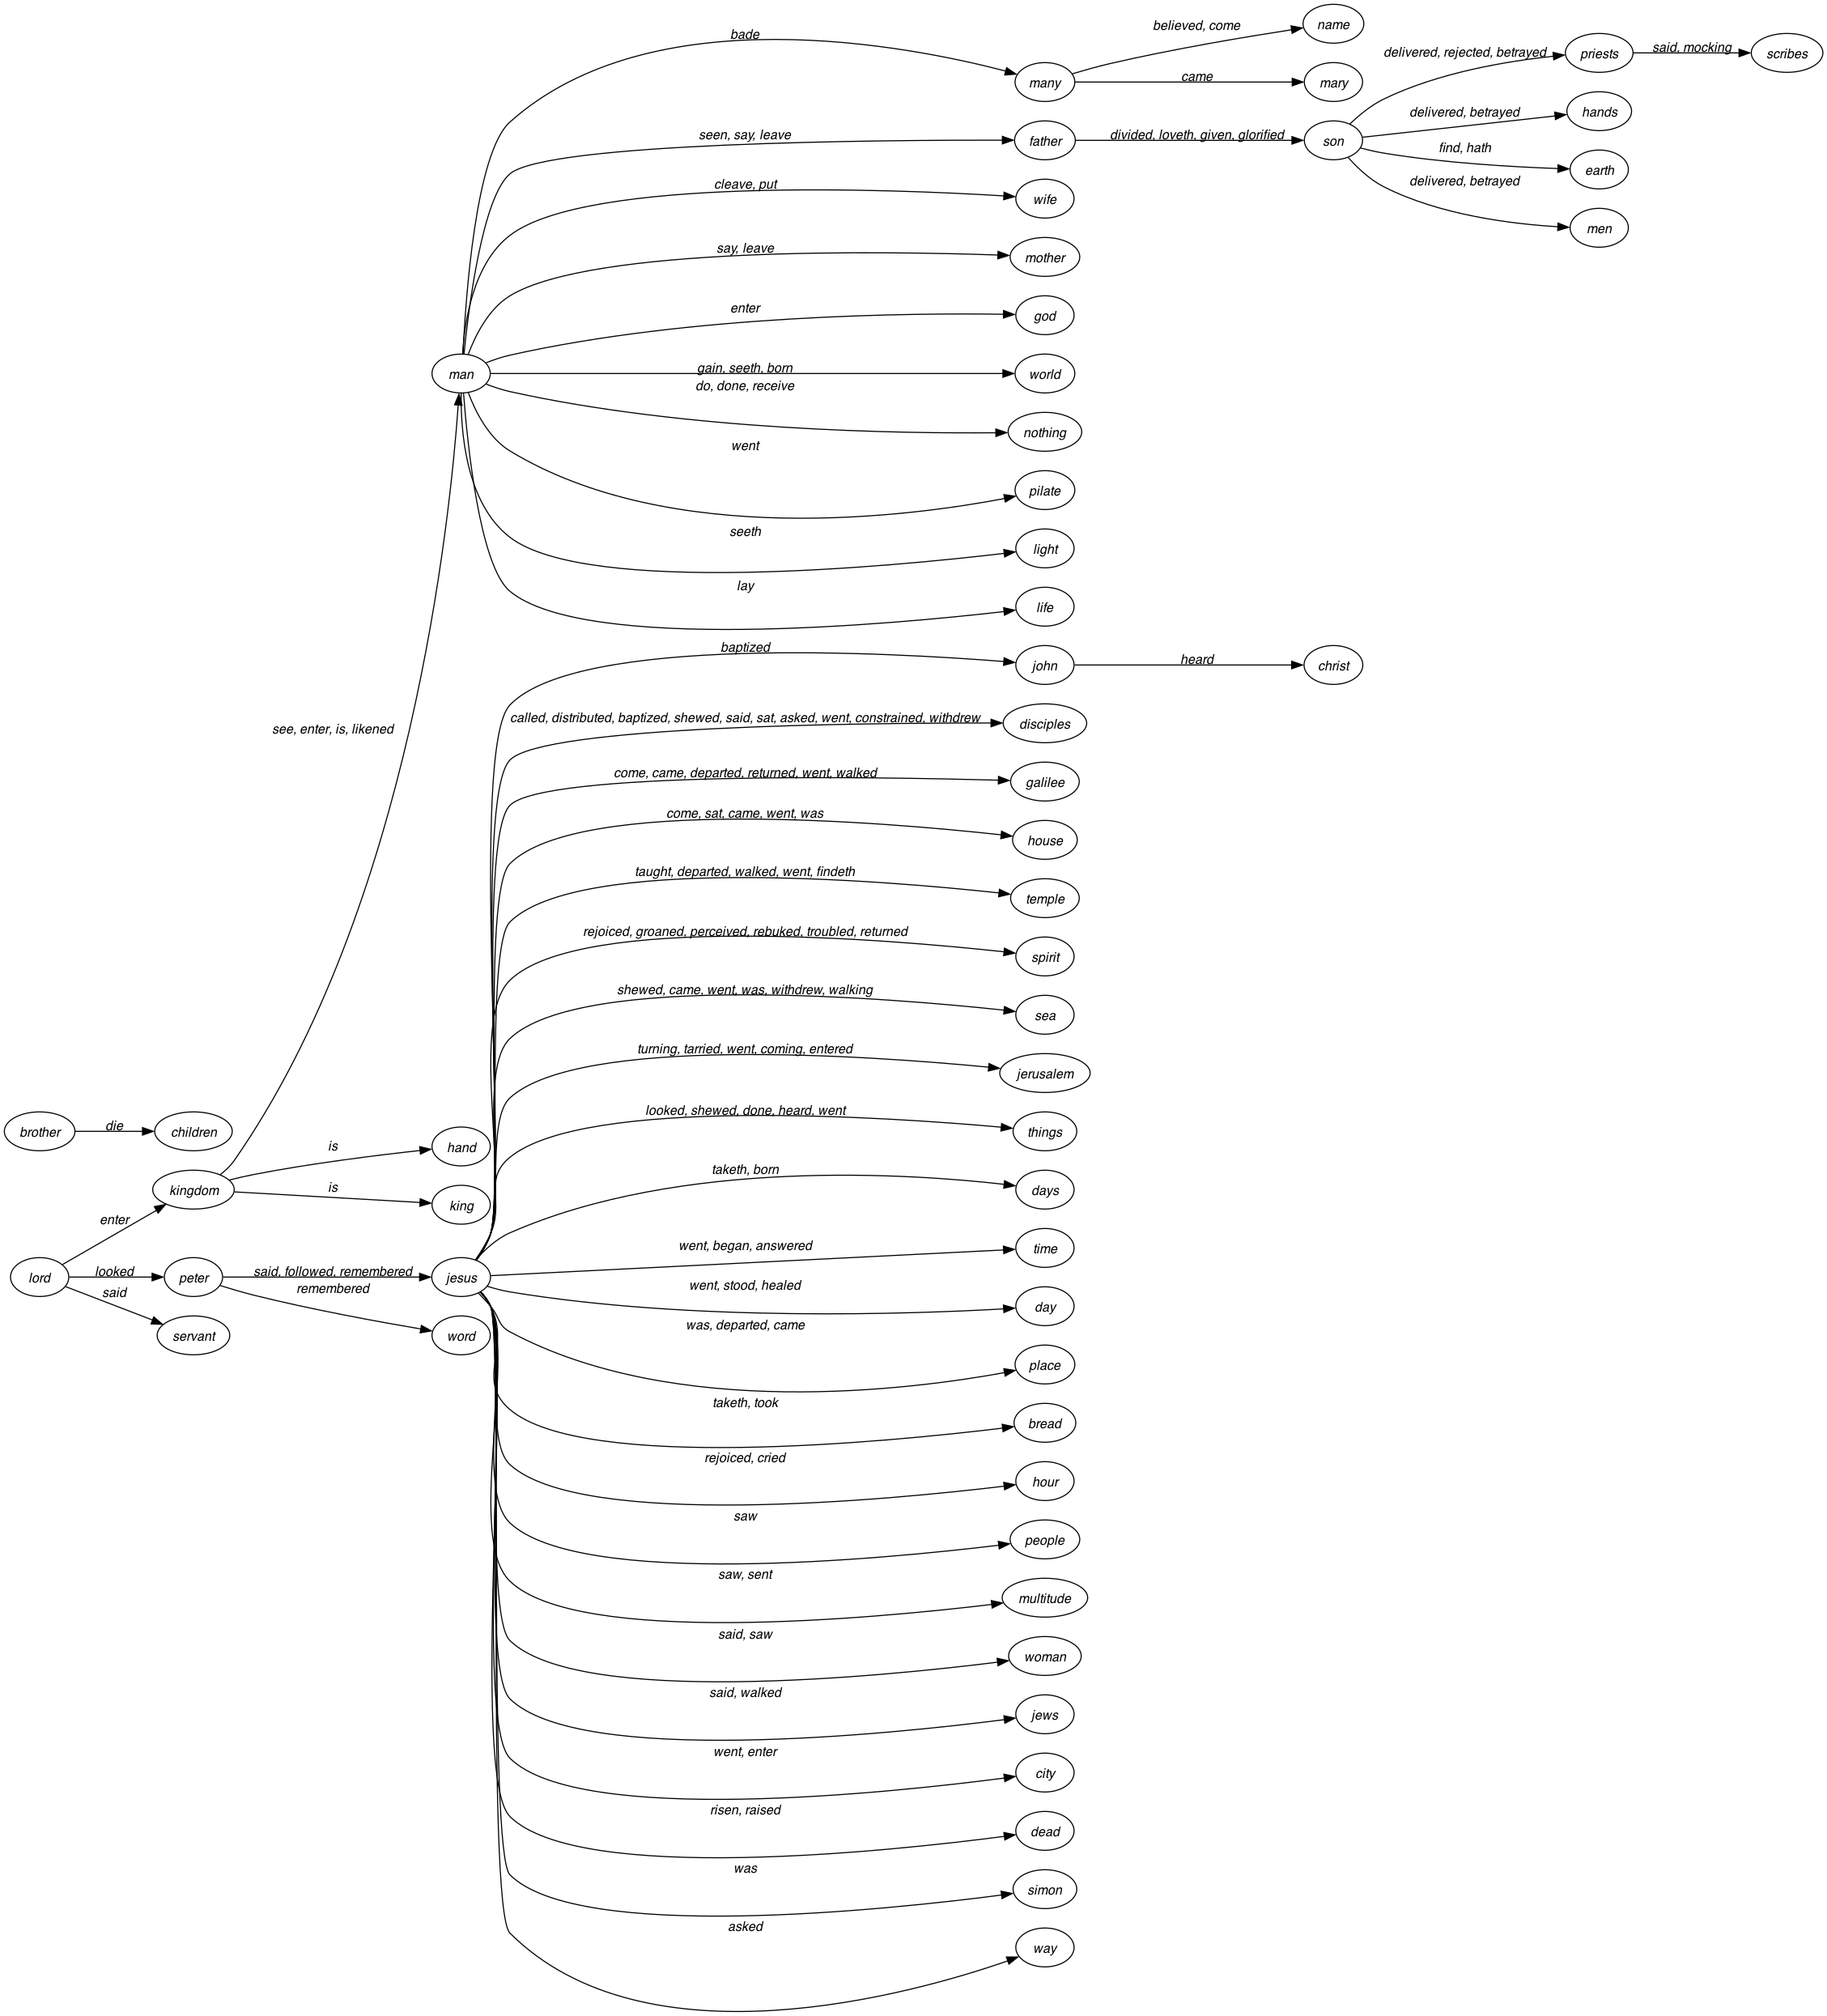

In [10]:
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=relations_to_verbs,
)